### Word segmentation analysis of DGA domains

In this notebook, we've explored Natural Language Processing techniques to segment the domain labels further into smaller chunks of meaningful words, and see if some metrics based on such segmentation are able to show any appreciable difference between the DGA and non-DGA categories. 

In [3]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import re
from wordfreq import zipf_frequency

In [4]:
# read DGA and Cisco high confidence data
dga_df = pd.read_csv('..\\data\\2018_0923\\dga-feed-high.csv', header=None, skiprows=15)
cisco_df = pd.read_csv('..\\data\\2018_0923\\top-1m.csv', header=None)

In [5]:
path_plots = '.\\plots'

In [6]:
# display head
def display_df(dga_df_, cisco_df_):
    display("DGA feed sample: {}".format( dga_df_.shape) )
    display(dga_df_.head())
    display("Cisco feed sample: {}".format( cisco_df_.shape) )
    display(cisco_df_.head())

display_df(dga_df, cisco_df)
print(dga_df.shape)

'DGA feed sample: (381953, 4)'

,0,1,2,3
0,plvklpgwivery.com,Domain used by Cryptolocker - Flashback DGA fo...,2018-06-23,http://osint.bambenekconsulting.com/manual/cl.txt
1,dnuxdhcgblsgy.net,Domain used by Cryptolocker - Flashback DGA fo...,2018-06-23,http://osint.bambenekconsulting.com/manual/cl.txt
2,qjlullhfkiowp.biz,Domain used by Cryptolocker - Flashback DGA fo...,2018-06-23,http://osint.bambenekconsulting.com/manual/cl.txt
3,elkidddodxdly.ru,Domain used by Cryptolocker - Flashback DGA fo...,2018-06-23,http://osint.bambenekconsulting.com/manual/cl.txt
4,rnbfwuprlwfor.org,Domain used by Cryptolocker - Flashback DGA fo...,2018-06-23,http://osint.bambenekconsulting.com/manual/cl.txt


'Cisco feed sample: (1000000, 2)'

,0,1
0,1,netflix.com
1,2,api-global.netflix.com
2,3,prod.netflix.com
3,4,push.prod.netflix.com
4,5,google.com


(381953, 4)


In [7]:
# remove unused columns, add otuput label 'dga'
dga_df_slim =   dga_df.drop(columns=range(1,dga_df.shape[1]), inplace=False)
dga_df_slim.columns = ['domain']
cisco_df_slim = cisco_df.drop(columns=[0], inplace=False)
cisco_df_slim.columns = ['domain']
dga_df_slim['dga'] = 1
cisco_df_slim['dga'] = 0

display_df(dga_df_slim, cisco_df_slim)
unified_df = pd.concat([cisco_df_slim, dga_df_slim], ignore_index=True)
unified_df['scoreMetrics'] = None
unified_df.head()

'DGA feed sample: (381953, 2)'

,domain,dga
0,plvklpgwivery.com,1
1,dnuxdhcgblsgy.net,1
2,qjlullhfkiowp.biz,1
3,elkidddodxdly.ru,1
4,rnbfwuprlwfor.org,1


'Cisco feed sample: (1000000, 2)'

,domain,dga
0,netflix.com,0
1,api-global.netflix.com,0
2,prod.netflix.com,0
3,push.prod.netflix.com,0
4,google.com,0


,domain,dga,scoreMetrics
0,netflix.com,0,None
1,api-global.netflix.com,0,None
2,prod.netflix.com,0,None
3,push.prod.netflix.com,0,None
4,google.com,0,None


In [8]:
# Functions to score the text - domain, or lables, and its segments

NA_score = 200.0                                   # penalty score of a text not in vocabulary
BIGRAM_score = 100.0                                # penalty score for bigram

all_alphas = set(string.ascii_lowercase)
valid_unigrams = set([])
#valid_unigrams = set(['a', 'i', 'u'])
invalid_unigrams = all_alphas - valid_unigrams

def scoreTextSegment(iStart, iStop, text):
    """ returns the score of a segment of text agaist the word frequency
    
    Args:
        iStart: starting index within the input text
        iStop:  starting index within the input text
        text:   input text
    Returns:
        log probability score of the text segment
    """
    global invalid_unigrams
    global NA_score
    
    if text[iStart:iStop] in invalid_unigrams:
        return NA_score
    elif iStop-iStart == 2:
        return BIGRAM_score
    else:
        act_freq = zipf_frequency(text[iStart:iStop], 'en', 'small')
        if act_freq == 0.0:
            return NA_score
        else:
            return act_freq

def scoreBestSegments(input_text, verbosity=0, scoreFn=scoreTextSegment):
    """optionally split the text to determine cutpoints for highest scoring

    Args:
      input_text: input text to segment
      scoreFn:    a function that accepts "start" and "stop" segments of the text
                  and gives back the score of the segment extending from [start, stop)
    
    Returns:
      The best score determined from segmentation.
    """
    n = len(input_text)
    leftScore = []
    distinct_segs = set()

    for k in range(n + 1):
        leftScore.append((scoreFn(0, k, input_text), []))
        last_idx = 0
        
        for j in range(k):
            
            newScore = leftScore[j][0] + scoreFn(j, k, input_text)
            if( newScore <  leftScore[k][0] ):
                
                if verbosity >= 4:
                    print("For K ={:2d} found better split at: {:2d}, Old : {:10.2f} New =  {:10.2f}, {:s}"
                          .format(k,j, leftScore[k][0], newScore, input_text[last_idx:j]))
                
                leftScore[k] = ( newScore, leftScore[j][1] + [j] )
                last_idx = j
        
        if verbosity >= 4:
            print("Final split for K= {:2d} = {}\n".format(k, leftScore[k][1]))
    
    last_idx = 0
    for i in leftScore[n][1]:
        distinct_segs.update([(input_text[last_idx:i])])
        last_idx = i
    distinct_segs.update([input_text[last_idx:]])

    return leftScore[n][0], leftScore[n][1], distinct_segs



In [9]:
# Printing functions

def segment_and_print(inpText, verbosity=0):
    """Prints the segments of text
       
       Args:
           text: input text to optimally segment
        
       Returns:
           text segmentation output
    """
    score, segment_list, dontcare = scoreBestSegments(inpText, verbosity=verbosity)
    last_idx = 0
    print("\nSegmented text for '{}':".format(inpText))
    for idx in segment_list:
        print(inpText[last_idx:int(idx)], end=' ')
        last_idx = int(idx)
    print(inpText[last_idx:])

def print_segments(inpText, segment_list):
    """Prints the segments of text
       
       Args:
           text: input text to optimally segment
           segment_list: a list of boundary indices of the segments
        
       Returns:
           text segmentation output
    """
    last_idx = 0
    for idx in segment_list:
        print(inpText[last_idx:idx], end=' ')
        last_idx = idx
    print(inpText[last_idx:l])

Here is a definition of a domain scoring functon.  
**At the end, there are some raw as well as normalized metrics used for scoring.**

In [10]:
# Wrapper function for scoring domain 

def scoreDomain(inRow, verbosity=0):
    """ Splits the domain by labels (dot separator) and
        optimally segments each label into words based on 
        word frequency (wordfreq) corpus.
        
        Args:
            inRow: input row of the domain dataframe
        
        Returns:
            score: scoring of the domain
    """
    thisDomain = inRow['domain']
    num_digits = sum( char.isdigit() for char in thisDomain)
    
    if verbosity >= 2:
        print("\n", "="*5, thisDomain, "="*5)
    
    
    labels = thisDomain.lower()
    #labels = labels.split('.')
    labels = re.split('\W+', labels)        # separate the domain labels
    #labels.pop(-1)                          # drop TLD label
    thisScore = []
    unique_words = set()
    for i,label in enumerate(labels):
        iScore, iSegs, word_set = scoreBestSegments(label, verbosity)
        thisScore.append(iScore)
        unique_words.update(word_set)
        if verbosity >= 2:
            print("Score for label '{:30s}' = {:6.3f}, unique_words = {:d} {}"
                  .format(label, thisScore[i], len(word_set), word_set))
    
    
    
    return [sum(thisScore),                      # return total score for the domain
            sum(thisScore) / len(thisDomain),    # total score normalized bu domain length
            len(unique_words),                   # number of unique words in domain
            len(unique_words) / len(thisDomain), # number of unique words in domain normalized by its length
            num_digits,                          # number of digits in the domain name 
            num_digits / len(thisDomain)]        # number of digits in domain name normalized by length
            
            

Here is an example of how the segmentation of a domain name looks like:  
  
- The scores of frequent words, or atleast that are present in the dictionary (*of the wordfreq package*), are on the low side, implying there is less penalty for such a segment.  
- On the other hand, a segment of an infrequent word, or a jumbled bunch of characters, has a high penalty.  

Scores from all such segments are then accumulated, and reported raw or normalized by one of the normalizing measures - domain character length, or total number of segments, or number of unique segments.  
  
The hypothesis is that overall, the DGA domains should have higher cost of segmentation than non-DGA domains, implying that they have less in common with the english vocabulary.

In [11]:
# Testing segmentation code
print("\n--Text segmentation--")
random_domain = 'globalvaluecommerce.com'
segment_and_print(random_domain, verbosity=1)

print("\n--Domain scoring--")
domain_name = 'ipv4-c001-hfa001-cellcom-isp.1.oca.nflxvideo.net'
another_domain = pd.DataFrame(domain_name, index=[0], columns=['domain'])
another_domain.apply( lambda row: scoreDomain(row, verbosity=2), axis=1 )


--Text segmentation--

Segmented text for 'globalvaluecommerce.com':
global value commerce .com

--Domain scoring--

 ===== ipv4-c001-hfa001-cellcom-isp.1.oca.nflxvideo.net =====
Score for label 'ipv4                          ' = 200.000, unique_words = 1 {'ipv4'}
Score for label 'c001                          ' =  3.190, unique_words = 1 {'c001'}
Score for label 'hfa001                        ' = 103.680, unique_words = 2 {'a001', 'hf'}
Score for label 'cellcom                       ' =  8.880, unique_words = 2 {'com', 'cell'}
Score for label 'isp                           ' =  3.270, unique_words = 1 {'isp'}
Score for label '1                             ' =  6.020, unique_words = 1 {'1'}
Score for label 'oca                           ' = 200.000, unique_words = 1 {'oca'}
Score for label 'nflxvideo                     ' = 11.040, unique_words = 3 {'deo', 'nfl', 'xvi'}
Score for label 'net                           ' =  4.750, unique_words = 1 {'net'}


0    [540.8299999999999, 11.267291666666665, 13, 0....
dtype: object

In [17]:
debug_verbose = 1
samples = 20000

sampled_df = unified_df
#sampled_df = unified_df.sample(n=samples, random_state=3)

if debug_verbose:
    display(sampled_df.head(5))

sampled_df.scoreMetrics = sampled_df.apply( lambda row: scoreDomain(row, verbosity=debug_verbose), axis=1 )

if debug_verbose:
    print("After scoring:\n")
    display(sampled_df.head(5))

,domain,dga,scoreMetrics
0,netflix.com,0,None
1,api-global.netflix.com,0,None
2,prod.netflix.com,0,None
3,push.prod.netflix.com,0,None
4,google.com,0,None


After scoring:



,domain,dga,scoreMetrics
0,netflix.com,0,"[8.12, 0.7381818181818182, 2, 0.18181818181818..."
1,api-global.netflix.com,0,"[16.81, 0.764090909090909, 4, 0.18181818181818..."
2,prod.netflix.com,0,"[11.239999999999998, 0.7024999999999999, 3, 0...."
3,push.prod.netflix.com,0,"[16.0, 0.7619047619047619, 4, 0.19047619047619..."
4,google.com,0,"[8.829999999999998, 0.8829999999999998, 2, 0.2..."


In [18]:
# group score metrics by dga or non-dga 
sc_dga = sampled_df[sampled_df['dga']==1]['scoreMetrics']
display(sc_dga.head())
sc_nondga = sampled_df[sampled_df['dga']==0]['scoreMetrics']
display(sc_nondga.head())

1000000    [204.06, 12.003529411764706, 2, 0.117647058823...
1000001    [204.75, 12.044117647058824, 2, 0.117647058823...
1000002    [203.12, 11.948235294117648, 2, 0.117647058823...
1000003                     [300.0, 18.75, 2, 0.125, 0, 0.0]
1000004    [203.29, 11.958235294117646, 2, 0.117647058823...
Name: scoreMetrics, dtype: object

0    [8.12, 0.7381818181818182, 2, 0.18181818181818...
1    [16.81, 0.764090909090909, 4, 0.18181818181818...
2    [11.239999999999998, 0.7024999999999999, 3, 0....
3    [16.0, 0.7619047619047619, 4, 0.19047619047619...
4    [8.829999999999998, 0.8829999999999998, 2, 0.2...
Name: scoreMetrics, dtype: object

In [19]:
def retrieve_score( dframe, scoreIdx):
    return list(dframe.apply( lambda x: x[scoreIdx]))

In [42]:
def plot_hists_v2(dga_df, nondga_df, scoreType=0, scoreText='', filePrefix='EDA_', 
                  logScale='no', savefig='no', transprnt=False, colorTone='black', title=''):
    
    ''' dga_dg:      DGA dataframe
        nondga_df:   nonDGA dataframe
        scoreType:   integer representing one of the scores defined in scoreDomain()
        scoreText:   x-axis label
        filePrefix:  prefix to append to plots saved to file
        logScale:    'yes', 'no', or 'both' to use logarithmic scale for histogram frequency
        savefig:     figure saving to .png 'yes' to save, 'no' not save or 'only' save without displaying
        trsnprnt:    boolean for saved figure transparency
        textColor:   boolean for white text on a black background (skips inline plot)
        title:       chart title
    '''

    if colorTone == 'white':
        legend_facecolor = 'grey'
    else:
        legend_facecolor = 'inherit'
    params = {"ytick.color"       : colorTone,
              "xtick.color"       : colorTone,
              "axes.labelcolor"   : colorTone,
              "axes.edgecolor"    : colorTone,
              "legend.edgecolor"  : colorTone,
              "legend.facecolor"  : legend_facecolor,
              "text.color"        : colorTone,
              "grid.color"        : colorTone
             }
    plt.rcParams.update(params)
    
    dga_scores = retrieve_score(dga_df, scoreType)
    nondga_scores = retrieve_score(nondga_df, scoreType)
    
    logFlag = None
    if logScale == 'log':
        logFlag = True
    elif logScale == 'linear':
        logFlag = False
    
    if logScale != 'both':
        plt.figure(figsize=(12,6))
        
        plt.hist([dga_scores, nondga_scores], bins=20, color=['#eabe1b', '#4485f4'],
             log=logFlag, label = ['DGA domains (bad)', 'non-DGA domains (good)'],
             histtype='bar')
        plt.xlabel(scoreText)
        plt.ylabel("Frequency - " + logScale)
        plt.legend()
        plt.grid(True)
        plt.title(title)
    
    elif logScale == 'both':
        plt.figure(figsize=(16,6))
        
        plt.subplot(1, 2, 1)
        logScale = 'linear'
        plt.hist([dga_scores, nondga_scores], bins=20, color=['#eabe1b', '#4485f4'],
             log=False, label = ['DGA domains (bad)', 'non-DGA domains (good)'],
             histtype='bar')
        plt.xlabel(scoreText)
        plt.ylabel("Frequency - " + logScale)
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        logScale = 'log'
        plt.hist([dga_scores, nondga_scores], bins=20, color=['#eabe1b', '#4485f4'],
             log=True, label = ['DGA domains (bad)', 'non-DGA domains (good)'],
             histtype='bar')
        plt.xlabel(scoreText)
        plt.ylabel("Frequency - " + logScale)
        plt.legend()
        plt.grid(True)
        
        plt.suptitle(title)
        
    else:
        raise ValueError("Invlalid argument for logScale. Can only be 'yes', 'no' or 'both' ")
    
    #plt.xticks(range(0, 500))
    #plt.yticks(range(1, 2000))

    if type(savefig) != str:
        raise ValueError("Invalid type passed. Must be string.")    
    _savefig = savefig.lower()
    
    if _savefig == 'yes':
        plt.savefig(path_plots + '\\' + filePrefix + str(scoreText).
                    replace(' ', '_') + '.png', dpi=500, transparent=transprnt)
        plt.show()
    elif _savefig == 'no':
        plt.show()
    elif _savefig == 'only':
        plt.savefig(path_plots + '\\' + (filePrefix + str(scoreText).
                    replace(' ', '_')).lower() + '.png', dpi=300, transparent=transprnt)
    plt.close()     # required to flush out plot buffer

In [21]:
# function to generate plots

plots_dict = dict()
# x-axis labels
plots_dict[0] = ['Raw probability score']
plots_dict[1] = ['Normalized probability score']
plots_dict[2] = ['Distinct words']
plots_dict[3] = ['Normalized number of distinct words']
plots_dict[4] = ['Number of digits count']
plots_dict[5] = ['Normalized normalized number of digits count']

# chart title
chart_prefix = 'Scoring DGA/non-DGA based on: '
plots_dict[0].append(chart_prefix + 'cost of word segmentation')
plots_dict[1].append(chart_prefix + 'cost of word segmentation, normalized by domain length')
plots_dict[2].append(chart_prefix + 'number of distinct word segments')
plots_dict[3].append(chart_prefix + 'number of distinct words, normalized by domain length')
plots_dict[4].append(chart_prefix + 'number of digits count')
plots_dict[5].append(chart_prefix + 'number of digit count, normalized by domain length')

def process_plots(df_DGA, df_nonDGA, _logarith, choices, _fileName,
                  _saveplt, _trnspnt, _color, pltDict=plots_dict):
    
    if type(choices) == list:
        idxs = choices
    elif type(choices) == str and choices == 'all':
        idxs = range(len(plots_dict))
    else:
        raise ValueError("Invalid choices passed. Can either be a list of indices or 'all'.")

    for i in idxs:
        plot_hists_v2(df_DGA, df_nonDGA, i, pltDict[i][0], _fileName, 
                      _logarith, _saveplt, _trnspnt, _color, pltDict[i][1])

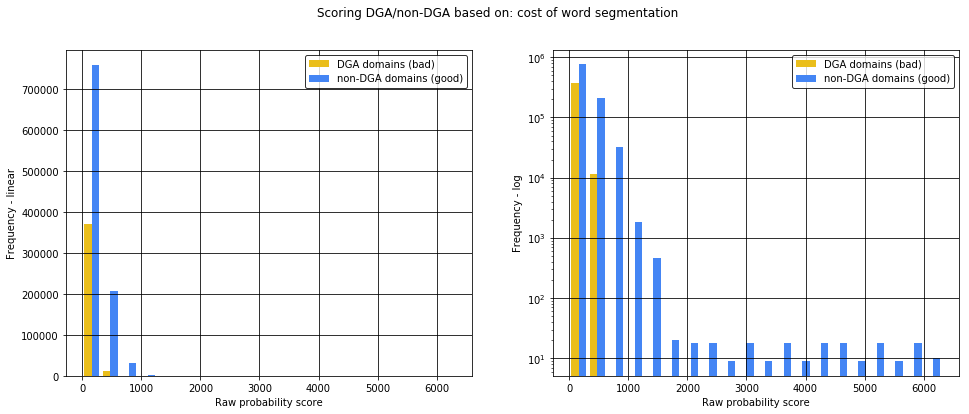

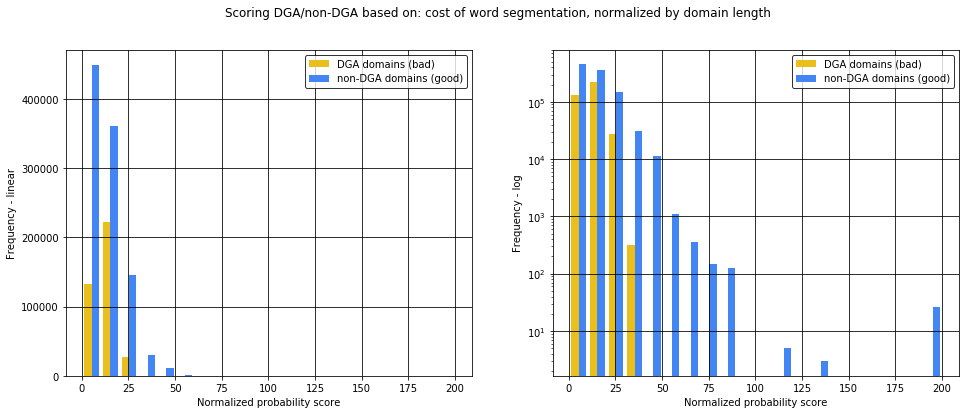

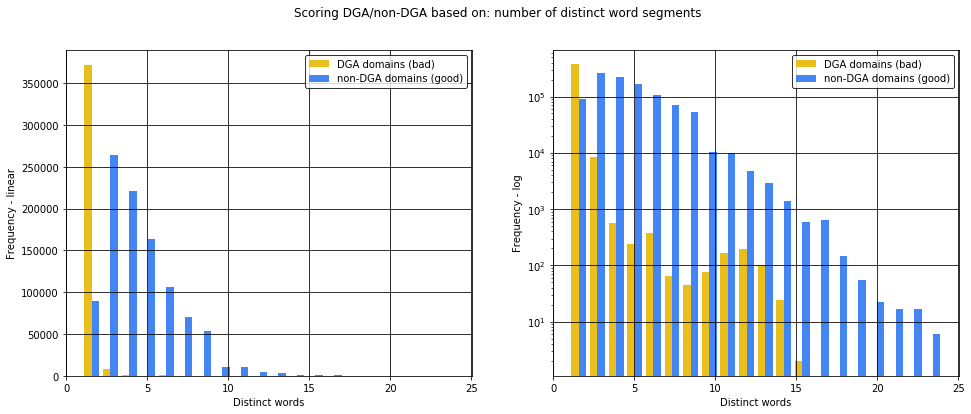

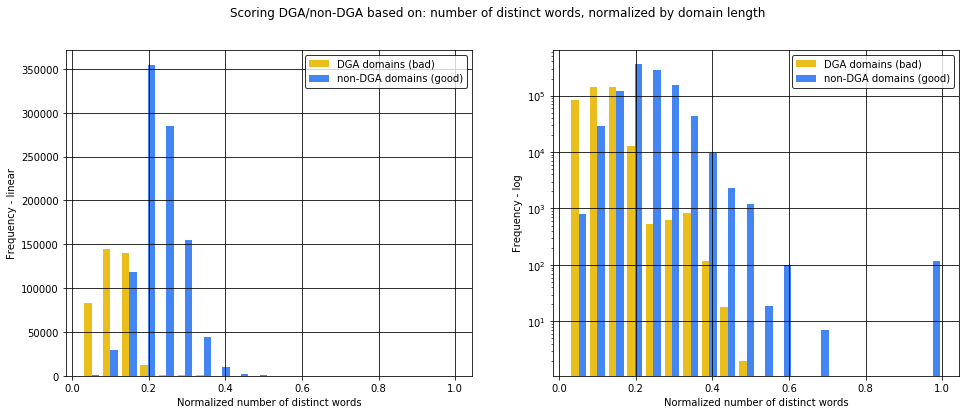

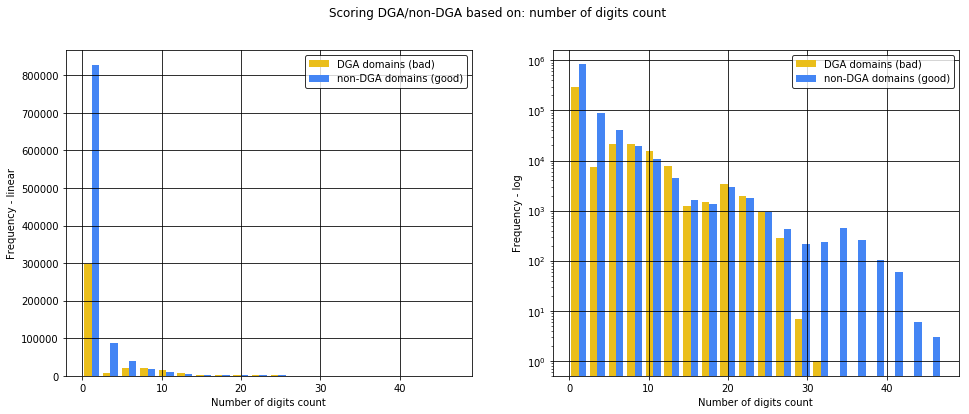

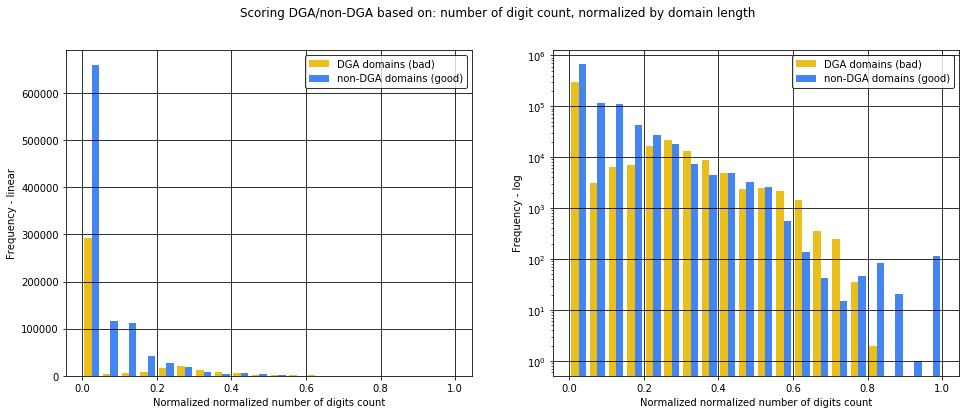

In [43]:
# display plots - linear and log scale side by side)

fileName = 'EDA_p2_SBS_'     # both plots side by side (SBS)
logarith = 'both'            # plot log and linear, both
saveplt  = 'yes'
transpnt = False
shade    = 'black'           # color to use for axes, labels, marks etc.
chosen   = 'all'             # specify plots#s in list, or all

process_plots(sc_dga, sc_nondga, logarith, chosen, fileName, saveplt, transpnt, shade)

In [44]:
# save transparent plots

fileName = 'requex_sbs_'
logarith = 'both'
saveplt  = 'only'
transpnt = True
shade    = 'white'
chosen   = 'all'

process_plots(sc_dga, sc_nondga, logarith, chosen, fileName, saveplt, transpnt, shade)

fileName = 'requex_linear_'
logarith = 'no'
process_plots(sc_dga, sc_nondga, logarith, chosen, fileName, saveplt, transpnt, shade)

fileName = 'requex_log_'
logarith = 'yes'
process_plots(sc_dga, sc_nondga, logarith, chosen, fileName, saveplt, transpnt, shade)

print("Plots successfully saved to disk!")

Plots successfully saved to disk!


### Conclusion

So far the strongest signal appears to be in the number of distinct words in the domain name, normalized by the domain length. There is atleast **an order** of difference between the two categories.

The other metrics as  
- raw/normalized scoring based on vocabulary contexts,  
- raw count of or normalized number of digit characters  
  
in the domain name don't seem to offer any appreciable differentiation between the DGA and non-DGA domains.